# Hidden Markov Models

In this notebook, I implement a Hidden Markov Model (HMM) with Gaussian Response variables based on text and code examples of Zucchini and MacDonald [1].

HMMs are characterized by the following [2]:

1. They try to infer **hidden** or **latent** states from discrete or continuous time-series data. Consider the image below. On the x-axis we have time, so this is a time-series dataset. On the y-axis we have four sleep stages (light, deep, REM sleep and wakefulness). These are the latent stages. My fitbit attempts to extract these stages based on my movement and heart rate for each point in the time-series. This results in a sequence of latent states. For the image below, that would look something like this: (Awake, REM, REM, REM, ..., Deep, Deep, REM, Deep, Deep, Awake, ...) and so on.

<img src="img/sleeeeeeping.PNG" width="500">

2. They are **memoryless** models [3]. When predicting the state at time point $t$, these models only look at the state at $t-1$ to infer the probability of transitioning into a next state. If the state at $t-1$ is REM, then what is the probability of observing the next state as REM, light, deep sleep or wakefulness? This is also called the *Markov assumption*.

3. Each state has its own **component distribution**, and the joint distribution of these component distribution is a **mixture distribution**. All this means is that we think that REM sleep, light sleep, deep sleep and wakefulness have different distributions when we consider movement and heart rate. This is easy enough to believe if you think about these variables; a person who is awake typically has a heart rate between 60-100 BPM, whereas a person in deep sleep has a heart rate of 50-60 BPM. If we believed these variables to be normally distributed, then we could model the heart rate component distributions using the means 75 for wakefulness and 55 for deep sleep. Depending on which heart rate we observe at each time step, we can compute the probability of seeing that observation for each of the component distributions. This procedure is how we translate observed data to latent states: which state typically fits this observed value best? 

Note that the mixture distribution in (3) is not independent. In independent mixture distributions (e.g. multivariate normal distribution) the observations are drawn without conditioning on a third variable (for example a sleep state at a specific point in time). In our case, however, the observations are drawn based on the previous state, and these probabilities are different for each state (this is the markov assumption mentioned in (2)). For example, it is not likely that you will go from wakefulness into REM sleep immediately, so the probability of seeing this state after observing a wakeful state is low. Conversely, it is very likely that you will go from light sleep to REM, so the probability associated with this transition is much higher.

### Notation

I use the following notation in this notebook, based on [1] and [2]. 

#### Observed data

For a time-series sequence of length $T$, let the observed outcome data (e.g. movement/heart rate) be denoted by:

$$
\tag{1}
X_{1:T} := (X_1, X_2, \dots, X_T)
$$

#### Component distributions

Let $m$ denote the number of components in the HMM. Then the component of the HMM at time $t$ is given by:

$$
\tag{2}
C_t = i, i \in \{1, 2, \dots, m\}
$$ 

The distribution $X_t$ of the observed data is considered to be dependent on the state $C_t$ (see point 3 above), so that we can write: 

$$
\tag{3}
p_i(X_t) := p(X_t | C_t = i)
$$ 

#### Marginal distributions

The marginal distribution (collapsed over all the states/components) is given by the following mixture distribution:

$$
\tag{4}
p(X_t) = \sum_{i=1}^m \delta_i p_i(X_t)
$$

where $\delta_i$ represents the proportion of observations in component $i$. If 30/100 observations are in the REM sleep component and 70/100 are in the wakefulness component, then the components of these distributions are $\vec{\delta} = [0.3, 0.7]$. This vector sums to unity $\sum \delta_i = 1$

#### Transition probabilities

The probability of observing $C_t$ at timestep $t$ is dependent on the state observed in the previous timestep. (see point 2 above):

$$
\tag{5}
p(C_t | C_1, \dots, C_{t-1}) = p(C_t|C_{t-1})
$$

These probabilities are called **transition probabilities** and govern the probability of moving from state $C_t$ to $C_{t+1}$ at timestep $t$ (e.g. from REM to deep sleep). They are collected in the **transition probability matrix** (TPM) $\pmb{\Gamma}(t) \in \mathbb{R}^{m \times m}$ such that:

$$
\tag{6}
\gamma_{ij}(t) := p(C_{t+1} =j | C_t = i), \ \ \forall i,j = 1, \dots, m
$$

The row-sums of the TPM sum to unity:

$$
\tag{7}
\sum_{j=1}^m \gamma_{ij}(t) = 1
$$

If the transition probabilities are time-homogenous, meaning that they are the same for each timestep $t \in T$, then $\pmb{\Gamma}(t) = \pmb{\Gamma}$.

#### Stationary distribution

If the HMM is **stationary** this means that the probability distribution of the $m$ components converges as $t \to \infty$. This vector is denoted by $\vec{\zeta} \in \mathbb{R}^{m \times 1}$ and it can be obtained by solving

$$
\tag{8}
\vec{\zeta} \cdot \pmb{\Gamma} = \vec{\zeta}
$$

This vector sums to unity: $\sum \zeta_i = 1$

#### Initial distribution

At time $t=1$, we must supply an initial probability distribution. This distribution is denoted by $\vec{\pi} \in \mathbb{R}^{m \times 1}$:

$$
\tag{9}
\pi_i := p(C_1 =i), \ \ \forall i \in 1, \dots, m 
$$

The elements of $\vec{\pi}$ determine in which state the HMM starts. We can then compute the probability distribution over the components at time $t$ as:

$$
\tag{10}
p(C_t = 1, C_t = 2, \dots, C_t = m) = \vec{\pi} \cdot \pmb{\Gamma}^{t-1} = \vec{\pi}(t)
$$

When the HMM is stationary, the initial state vector $\vec{\pi} = \vec{\zeta}$ 

## Simulating data for Gaussian response distributions

To simulate data suitable for an HMM model, we first create a sequence of observations based on a 'true' TPM and initial distribution. Then, depending on the state at each timestep $t$, we draw an observation from its component distribution.

### Simulating a hidden sequence

The code below simulates a sequence for $T=100$ for two components.

In [38]:
import numpy as np

# Number of components 
m = 2
# Timesteps t
T = 100
# Set seed
np.random.seed(563)
# Transition matrix
gamma = np.array([[0.33, 0.67],
                  [0.89, 0.11]])
# Initial states
pi = np.array([0.71, 0.29])
# Draw from one of the states with probability pi_i
# Generate sequence
seq = np.zeros(T, dtype = np.int32)
for t in range(T):
    if t == 0:
        # Draw from the initial distribution
        seq[t] = int(np.nonzero(np.random.multinomial(1, pi))[0])
    else:
        # Multiply the initial distribution with the TPM
        prob_states = np.dot(pi, np.linalg.matrix_power(gamma, t))
        seq[t] = int(np.nonzero(np.random.multinomial(1, prob_states))[0])

### Simulating observed data 

In the code below, we define two normally distributed component distributions:

1. $C = 1 \sim N(7, 2)$
2. $C = 2 \sim N(15, 4)$

For each timestep $t$, we check which component we have and then draw an observation from its component distribution.

In [39]:
# Allocate
X = np.zeros(T, dtype = np.float32)
# Set seed
np.random.seed(886)
# mu / sd of the component distribution
mu = np.array([7,15])
sd = np.array([2,4])
# Populate
for i in range(T):
    # Get state
    state = seq[i]
    # Draw from normal distribution
    X[i] = np.round(np.random.normal(mu[state], sd[state]), 4)

/home/jasper/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


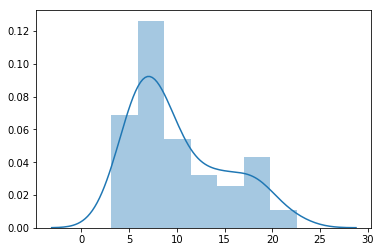

In [40]:
# Plot observed data
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.distplot(X)

## Estimating the state sequence

We now turn to estimating the state sequence from the observed data $X$ that we drew in the above code block. 

### Marginal distribution of $X$ and log-likelihood

In any directed graphical model, the joint distribution of a set of random variables $V_i$ is given by [1, pp. 33-35]:

$$
\tag{11}
p(V_1, V_2, \dots, V_n) = \prod_{i=1}^n p(V_i | pa(V_i))
$$

where $pa(V_i)$ denotes the 'parents' of $V_i$. See [this document](http://www.cs.columbia.edu/~blei/fogm/2015F/notes/graphical-models.pdf) for further details. 

For the random variables $X_t, X_{t+k}, C_t, C_{t+k}$, we can take the marginal by taking over the state sequences to get:

$$
\tag{12}
p(X_t = u, X_{t+k} = w) = \sum_{i=1}^m \sum_{j=1}^m p(C_t = i) p_i(v) p(C_{t+k} = j | C_t = i) p_j(w)
$$

In $(12)$, we can discern the following elements:

1. Recall that $\vec{\pi}(t) = \vec{\pi} \cdot \pmb{\Gamma}^{t-1}$, so that $p(C_t = i) = \vec{\pi}(t)$.
2. We let 

$$
p_i(v) = \text{diag}(p_i(v)) = \pmb{P}(v)\text{, and}\\ 
p_j(w) = \text{diag}(p_j(w)) = \pmb{P}(w)
$$ 

3. We see that $p(C_{t+k} = j | C_t = i) p_j(w) = \gamma_{ij}(k)$ and that $\sum_{i=1}^m \sum_{j=1}^m \gamma_{ij}(k) = \pmb{\Gamma}^k$

Then it follows that:

$$
\tag{13}
p(X_t = u, X_{t+k} = w) = \vec{\pi} \pmb{\Gamma}^{t-1} \pmb{P}(v) \pmb{\Gamma}^k \pmb{P}(w) \vec{1}
$$

Where $\vec{1}$ is an $m \times 1$ column vector of ones.

The result is a scalar which, at the final timestep, contains the likelihood of the HMM sequence.

### Forward algorithm

The algorithm we use to compute the likelihood is called the **forward algorithm**. Note that we are using the actual parameters (i.e. these should be unobserved) to compute the hidden state sequence).

The forward algorithm works as follows:

> 1. Define an initial distribution $\vec{\pi}$, transition probability matrix $\pmb{\Gamma}$ number of components $m$ and component distribution parameters $\vec{\mu} = [\mu_1, \dots, \mu_m]$ and $\vec{\sigma} = [\sigma_1, \dots, \sigma_m]$. Initialize a vector $S \in \mathbb{N}^{T \times 1}$ to hold the predicted state sequences.
> 2. Set $\vec{\alpha} = \vec{\pi}$ and set $S_1 := \text{arg max} \ \vec{\alpha}$.
> 3. For $x_t$ in $X$, do:
>     1. Compute the p.d.f. of $x_t$ for each of the component distributions $p_i$. 
>     2. Store the values of the component distributions in a matrix $\pmb{P}$.
>     3. Set the vector $\vec{\alpha}$ to be $\vec{\alpha}_t := \vec{\alpha}_{t-1} \pmb{\Gamma} \pmb{P}$
>     4. Set $S_t = \text{arg max} \ \vec{\alpha}_t$
> 4. At the final timestep $T$, compute the log-likelihood $L = \vec{\alpha}_t \vec{1}$

This algorithm is implemented in python code below.

In [8]:
# Forward algorithm
from scipy.stats import norm

# We use the initial probabilities pi
# NOTE: we shouldn't really know these ...

# Initialize alpha using the initial distribution
alpha = pi
# Initialize states to 0
states = np.zeros(T, dtype = np.int32)
# For each observation and timestep t, compute the state using the forward algorithm
for t, x in enumerate(X):
    # Compute probabilities for x at timestep t
    # Note that we are not assuming stationarity because we have alpha_1 = pi * P 
    #  at t == 1
    # Note that we are using population values mu and sd here
    p = norm.pdf(x, mu, sd)
    # Convert to diagonal matrix
    P = np.diag(p)
    # Form the matrix B
    B = np.dot(gamma, P)
    # Update alpha
    alpha = np.dot(alpha, B)
    # Add state
    states[t] = np.argmax(alpha)
    # At the last step, dot with 1' to get the likelihood
    if t == (T-1):
        L = np.dot(alpha, np.ones((m, 1), dtype = np.int32))

In [9]:
# Stack predicted and actual states column-wise
import pandas as pd
seqs = np.vstack((states,seq)).T
# Cast to data frame
print("First 10 observations ...")
pd.DataFrame(seqs, columns = ["predicted", "actual"]).head(10)

First 10 observations ...


,predicted,actual
0,1,1
1,0,1
2,1,1
3,0,0
4,1,0
5,0,0
6,0,0
7,0,0
8,1,1
9,0,0


In [10]:
# Print likelihood and alphas
print("Likelihood: {}".format(L))
print("Alphas at time T: {}".format(alpha))

Likelihood: [8.14757306e-129]
Alphas at time T: [4.30438168e-129 3.84319137e-129]


In the above implementation of the forward algorithm, clearly we are running into the issue of underflow. The values for the alphas are getting very small, and we need to start using some computational tricks to make sure we can handle longer sequences.

### Scaling the forward probabilities

To avoid underflow, we scale the forward probabilities $\vec{\alpha}(t)$ by the sum of this vector at time $t$:

$$
\tag{14}
\vec{\phi}(t) := \frac{\vec{\alpha}(t)}{\sum_{i=1}^m \alpha_{i}(t)}
$$

This has the effect of scaling the forward probabilities to values s.t. $\sum_{i=1}^m \phi_i(t) = 1$. 

### Computing the log-likelihood instead of the likelihood

If we let $\sum_{i=1}^m \alpha_{i}(t) = w_t$, then instead of computing $L = \vec{\alpha}_t \vec{1}$ at time $T$, we can now set $L = w_T$. However, this value can still get very small, so the natural thing to do is to compute the log-likelihood instead.

The likelihood in $(14)$ can be computed as:

$$
\tag{15}
L = w_T = \prod_{t=1}^T \frac{w_t}{w_{t-1}}
$$

Taking the log of $(15)$ yields:

$$
\tag{16}
\log{L} = LL = \sum_{t=1}^T \log{\frac{w_t}{w_{t-1}}} = \sum_{t=1}^T \log{\vec{\phi}_{t-1} \pmb{\Gamma} \pmb{P} \vec{1}}
$$

In [21]:
# Forward algorithm
from scipy.stats import norm

# Initialize alphas using the initial distribution
# scale the distribution by the sum of the alphas to prevent underflow
ones = np.ones((m, 1), dtype = np.int32)
phi = pi / np.dot(pi, ones) # ==> this is just scaling by 1 
# Initialize states to 0
states = np.zeros(T, dtype = np.int32)
# Initialize log-likelihood to 0
L = 0
# For each observation, compute the state using the forward algorithm
for t, x in enumerate(X):
    # Compute probabilities for x at timestep t
    p = norm.pdf(x, mu, sd)
    # Convert to diagonal matrix
    P = np.diag(p)
    # Form the matrix B
    B = np.dot(gamma, P)
    # Create the vector v as the product of scaled alphas and B
    v = np.dot(phi, B)
    # Create the scalar u as the sum of the scaled alphas
    u = np.dot(v, ones)
    # Add to log-likelihood
    L += np.log(u)
    # Scale vector by the sum of v to create new phi
    phi = v / u
    # Add state
    states[t] = np.argmax(phi)

In [22]:
# Stack predicted and actual states column-wise
import pandas as pd
seqs = np.vstack((states,seq)).T
# Cast to data frame
print("First 10 observations ...")
pd.DataFrame(seqs, columns = ["predicted", "actual"]).head(10)

First 10 observations ...


,predicted,actual
0,1,1
1,0,1
2,1,1
3,0,0
4,1,0
5,0,0
6,0,0
7,0,0
8,1,1
9,0,0


In [23]:
# Print likelihood and alphas
print("Log-Likelihood: {}".format(L))
print("Phi at time T: {}".format(phi))

Log-Likelihood: [-294.9357569]
Phi at time T: [0.52830231 0.47169769]


The above algorithm is defined as the function `HMM_forward` in the code block below.

In [24]:
def HMM_forward(X: np.array, pi: np.array, gamma: np.array, 
                mu: np.array, sd: np.array, return_states = False):
    
    """
    Compute the forward step of an HMM
    
    :param X: n x 1 numpy array containing the observed data
    :param pi: m x 1 numpy array containing initial values
    :param gamma: m x m numpy array containing transition probabilities
    :param mu: m x 1 numpy array containing means of component distributions
    :param sd: m x 1 numpy array containing sds of component distributions
    :param return_states: boolean. If True, then the state sequence is returned
    
    :return: Log-Likelihood and, if desired, the state sequence
    """
    
    # For dimensions
    m = mu.shape[0]
    T = X.shape[0]
    
    # Initialize alphas using the initial distribution
    # scale the distribution by the sum of the alphas to prevent underflow
    ones = np.ones((m, 1), dtype = np.int32)
    phi = pi 
    # Initialize states to 0
    if return_states: states = np.zeros(T, dtype = np.int32)
    # Initialize log-likelihood to 0
    L = 0
    # For each observation, compute the state using the forward algorithm
    for t, x in enumerate(X):
        # Compute probabilities for x at timestep t
        p = norm.pdf(x, mu, sd)
        # Convert to diagonal matrix
        P = np.diag(p)
        # Form the matrix B
        B = np.dot(gamma, P)
        # Create the vector v as the product of scaled alphas and B
        v = np.dot(phi, B)
        # Create the scalar u as the sum of the scaled alphas
        u = np.dot(v, ones)
        # Add to log-likelihood
        L += np.log(u)
        # Scale vector by the sum of v to create new phi
        phi = v / u
        # Add state
        if return_states: states[t] = np.argmax(phi)
        
    # Return
    if return_states:
        return((L, states))
    else:
        return(L)

## Optimization using an unconstrained optimizer

Given the observed data $X$, we want to find those values of the parameters (means, variances, transition probabilities) that maximize the likelihood of the state sequence. This is an optimization problem that we can solve using scipy's `minimize` function.

### Dealing with constraints

For the HMM with normal distribution we have no real constraints on the parameters $\mu_1, \mu_2, \sigma^2_1, \sigma^2_2$ since they are continuous and can take on any value. However, we have a constraint on the transition probability matrix $\pmb{\Gamma}$ because its rows must sum to one.

Given that the TPM has $m \times (m-1)$ free parameters (since the rows must sum to one), we can redefine the TPM using only the off-diagonal elements.

In [25]:
def transform_tpm(gamma: np.array) -> dict:
    
    """
    Transform the transition probability matrix gamma using the function g(x) = exp(x)
    """
    
    # Apply transformation of gamma
    # NOTE: have to reshape this as a column vector to make it compatible with R implementation
    tgamma = np.log(gamma / np.diag(gamma).reshape((gamma.shape[0],1)))
    # Retrieve off-diagonal elements
    # NOTE: have to reverse the nonzero elements to make it compatible with R implementation
    idx_tau = np.nonzero(tgamma)[::-1]
    # Retrieve nonzero elements
    tgamma_flat = tgamma[idx_tau]
    # Return values of transformation and indices
    return({"tgamma": tgamma_flat, "tgamma_idx": idx_tau})

def transform_tgamma(tgamma: dict) -> np.array:
    
    """
    Transform the transformed values of gamma back to probabilities
    """
    
    # Get values from dict
    tgamma, tgamma_idx = tgamma.values()
    # Identity matrix
    z = np.eye(tgamma_idx[0].shape[0])
    # Fill off-diagonal elements
    z[tgamma_idx] = np.exp(tgamma)
    # Scale
    z /= np.sum(z, axis=1).reshape((z.shape[0], 1))
    # Solve for delta (initial values)
    delta = np.linalg.solve((np.eye(z.shape[0]) - z + 1).T, np.ones(z.shape[0]))
    # Return
    return((z, delta))

If we do this for the true transition matrix, we get the following results.

In [26]:
# Transform the transition probability matrix
a = transform_tpm(gamma)
# Transform back and solve for delta
gam, delta = transform_tgamma(a)
# Print
print(gam)
print(delta)

[[0.33 0.67]
 [0.89 0.11]]
[0.57051282 0.42948718]


### Starting values

To assign starting values for the parameters, we can do the following:

1. For means, we can divide the observations into $k$ subsets using quartiles/quantiles and take the mean of the subsets.
2. For variances, we can take the variance of the $k$ subsets.
3. For initial transition probabilities, we can initialize the matrix $\pmb{\Gamma}$ using a uniform distribution with small values (e.g. 0.01 - 0.05) or initialize all values using the same, small value (e.g. 0.01).

In [31]:
# Initial values 
gamma_init = np.array([[0.99, 0.01],
                       [0.01, 0.99]])
# Split observed data at median
gr1 = X[X < np.median(X)]
gr2 = X[X >= np.median(X)]
# Construct means / variances
mu = np.array([np.mean(gr1), np.mean(gr2)])
sd = np.array([np.sqrt(np.var(gr1)), np.sqrt(np.mean(gr2))])

In [32]:
# Minimize function only takes a single array, so we need to add all parameters to
#  a single array
tgamma, tgamma_idx = transform_tpm(gamma_init).values()
# Concatenate values to flat array
x0 = np.concatenate([tgamma, mu, sd])
x0

array([-4.59511985, -4.59511985,  6.25819826, 14.03505325,  1.37487519,
        3.74633861])

The function below computes the Log-Likelihood given the input parameters.

In [41]:
from scipy.optimize import minimize

def HMM(parameters: np.array, *args: tuple) -> float:
    
    """
    Given an array of parameters, compute the log-likelihood of the HMM
    
    :param parameters: parameters passed to the model. This is a single (flat)
                        numpy array whose valuese correspond to the following 
                        parameters:
                         (1) indices 0:(m*(m-1)) ==> transformed values of the 
                              transition matrix
                         (2) indices (m*(m-1)):[(m*(m-1))+m] ==> means of the 
                              component distributions
                         (3) indices [(m*(m-1))+m]:[(m*(m-1))+2*m] ==> variances
                              of the component distributions
    :param *args: additional parameters passed to the function:
                         (1) args[0] ==> number of components
                         (2) args[1] ==> tuple of numpy arrays used to transform
                                          the transformed gamma values back to
                                          their original form
                         (3) args[2] ==> T-length numpy array containing observed
                                          data
                                          
    :return: Log-Likelihood of the model given the parameters
                                          
    :seealso: functions transform_tpm() and transform_tgamma() above
    
    :seealso: Zucchini, W., MacDonald, I. L., & Langrock, R. (2017). Hidden Markov 
                             models for time series: an introduction using R. 
                             Chapman and Hall/CRC. Chapters 2-3
    """
    
    # Args is the size of the 2x2 gamma matrix and the tgamma idices to backtransform to gamma
    m = args[0]
    tgamma_idx = args[1]
    X = args[2]
    
    # Unroll parameters
    tgamma = parameters[:(m*(m-1))]
    mu = parameters[(m*(m-1)):(m*(m-1)+m)]
    sd = parameters[(m*(m-1)+m):(m*(m-1)+2*m)]
    
    # Transform working parameters to natural parameters 
    # And solve for delta (initial values)
    gamma, pi = transform_tgamma({"tgamma": tgamma, "tgamma_idx": tgamma_idx})
    
    # Compute LL
    L = HMM_forward(X, pi, gamma, mu, sd, return_states = False)
    
    # Return log-likelihood
    return( -1 * L[0] )

We use a non-linear Newton-like algorithm to search for a good set of parameters that maximize the hidden state sequence.

In [ ]:
# Use optimize function from scipy
res = minimize(HMM, x0, args = (m, tgamma_idx, X), method = "L-BFGS-B",
               options = {'disp':True})

In [37]:
# Transform gamma and pi
gamma_pred, pi_pred = transform_tgamma({"tgamma":res.x[:2], "tgamma_idx":tgamma_idx})
# Construct mu, sd
mu_pred = res.x[2:4]
sd_pred = res.x[4:6]

In [86]:
# Compute state sequences
_, states_pred = HMM_forward(X, pi_pred, gamma_pred, mu_pred, sd_pred, 
                             return_states = True)

In [87]:
# Stack predicted and actual states column-wise
import pandas as pd
seqs = np.vstack((states_pred,seq)).T
# Cast to data frame
print("First 10 observations ...")
print("Steps correct: {}%".format(np.round(sum(states_pred == seq) / len(seq),4) * 100))
pd.DataFrame(seqs, columns = ["predicted", "actual"]).head(10)

First 10 observations ...
Steps correct: 95.0%


,predicted,actual
0,0,0
1,0,0
2,0,0
3,0,0
4,1,0
5,1,1
6,0,0
7,1,1
8,0,0
9,1,1


## Optimization using Expectation-Maximization (EM) 

The function below is a general, recursive function that can be used to compute the likelihood and state sequence.

In [ ]:
def HMM_EM(X: np.array, phi: np.array, gamma: np.array, k: int, **kwargs) -> tuple:
    
    """
    Use forward algorithm to compute the state sequence and Log-Likelihood
    
    :param X: Observed data
    :param phi: Initial distribution
    :param gamma: Transition Probability Matrix 
    :param k: Number of hidden states
    
    :return: tuple containing 
        (1) state sequence as T-dimensional array
        (2) Log-Likelihood
    """
    
    # Initialize alphas using the initial distribution
    # scale the distribution by the sum of the alphas to prevent underflow
    ones = np.ones((k, 1), dtype = np.int32)
    # If states not supplied, initialize them
    if kwargs.get("states") is None:
        # Initialize states to 0
        states = np.zeros(X.shape[0], dtype = np.int32)
    else:
        states = kwargs["states"]
    # Initialize log-likelihood to 0 if not passed
    if kwargs.get("L") is None:
        L = kwargs["L"]
    else:
        L = 0
        
    # ...
    pass

## References

[1] Zucchini, W., MacDonald, I. L., & Langrock, R. (2017). Hidden Markov models for time series: an introduction using R. Chapman and Hall/CRC. <br>
[2] Visser, I. (2011). Seven things to remember about hidden Markov models: A tutorial on Markovian models for time series. Journal of Mathematical Psychology, 55(6), 403-415. <br>
[3] Aarts, E. (2016). Beyond the average: Choosing and improving statistical methods to optimize inference from complex neuroscience data.